# Load data

In [88]:
import numpy as np
import pandas as pd
data = pd.read_csv(r"stem_loop/summary_20231011.csv")
y_total = []
X = []

# Data cleaning

In [52]:
for dG in set(data['dG']):
    y = data[data['dG']==dG]['GFP/RFP']
    p90 = np.percentile(data, 90)
    p10 = np.percentile(data, 10)
    mask = y >= p10
    y = y[mask]
    mask = y <= p90
    y = y[mask]
    y_total.extend(y)
    X.extend([dG]*y.shape[0])
y = np.log(np.array(y_total))
X = np.array(X).reshape(-1,1)

# Run SVR

In [53]:
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVR
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

svr = SVR(kernel='rbf') 

params = {'C': np.logspace(-2, 2, 20), 
          'gamma': np.logspace(-3, 0, 20)}

grid_search = GridSearchCV(svr, param_grid=params, cv=5, n_jobs=-1)

grid_search.fit(X_train, y_train)

print(grid_search.best_params_)

best_svr = grid_search.best_estimator_

y_pred = best_svr.predict(X_test)
r2 = r2_score(y_true=y_test, y_pred=y_pred)

{'C': 3.359818286283781, 'gamma': 0.001}


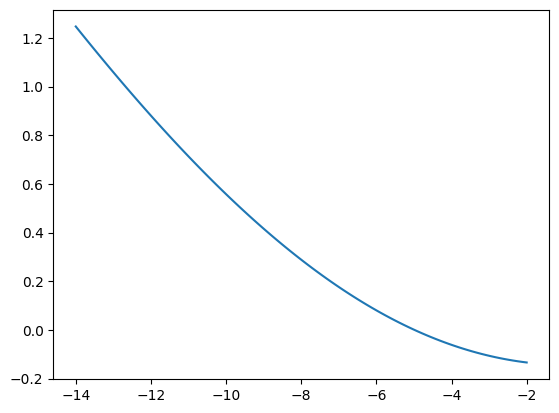

In [54]:
import matplotlib.pyplot as plt
x = np.linspace(-2,-14,100).reshape(-1,1)
y_pred = best_svr.predict(x)
plt.plot(x, y_pred)

# Visualization

In [99]:
import joblib
svr = joblib.load(r"stem_loop/model.joblib")
y_error_upper = []
y_error_lower = []
y_mediam = []
x = []
for dG in set(data['dG']):
    # data cleaning
    y = data[data['dG']==dG]['GFP/RFP']
    p90 = np.percentile(data, 90)
    p10 = np.percentile(data, 10)
    mask = y >= p10
    y = y[mask]
    mask = y <= p90
    y = y[mask]
    y = np.log(np.array(y))
    p75 = np.percentile(y, 75)
    p25 = np.percentile(y, 25)
    y_error_upper.append(p75 - np.median(y))
    y_error_lower.append(np.median(y) - p25)
    y_mediam.append(np.median(y))
    x.append(dG)

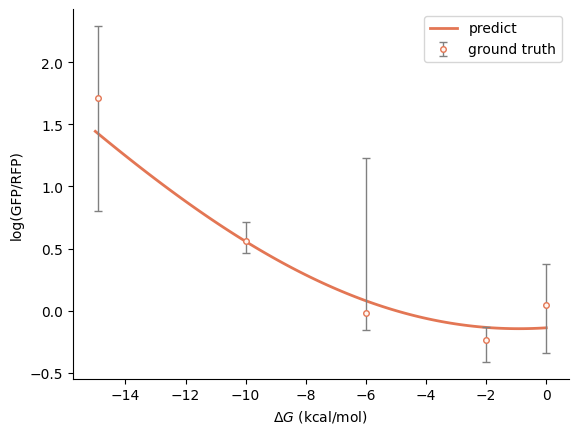

In [133]:
import matplotlib.pyplot as plt
X = np.linspace(0,-15,100).reshape(-1,1)
y_pred = best_svr.predict(X)
fig, ax = plt.subplots()
plt.plot(X, y_pred,color="#e37654",linewidth=2, label='predict')
plt.errorbar(x, y_mediam, yerr=[y_error_lower, y_error_upper], fmt='.', ecolor='grey', ms=8, mec="#e37654", mfc="#fff6f0", elinewidth=1, capsize=3, label='ground truth')
plt.xlabel('$ \Delta G $ (kcal/mol)')
plt.ylabel('log(GFP/RFP)')
ax.spines.right.set_visible(False)
ax.spines.top.set_visible(False)
ax.legend()
plt.savefig("result.svg", dpi=None)